# Point source extraction using CNN
This is a tutorial about how you can train a convolutional filter to increase signal to noise ratio.

In [1]:
import sys
import glob
import numpy as np

# Add pydeepkat directory
sys.path.insert(0,'../')
import pydeepkat as pk

import matplotlib.pylab as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

The data we want to increase its signal to noise are radio images. "PreProcessDataProvider" class makes random patches from them by specifiying container directories and names conditions of images and coresponding models files. Image and model file names will be fetched using glob. Model files includes gounrd truth of point source positions. You can make an instance like: 

In [28]:
ppdp = pk.PreProcessDataProvider(files_path='../../data/24sep/train_set/*robust-0*.fits',
                                     nx=200, ny=200)

number of files:  3


nx and nx are patch size. You can specify the number of required patches and call the innstance to get a random patch. It returns a patch of image and corresponding demand. They look like:

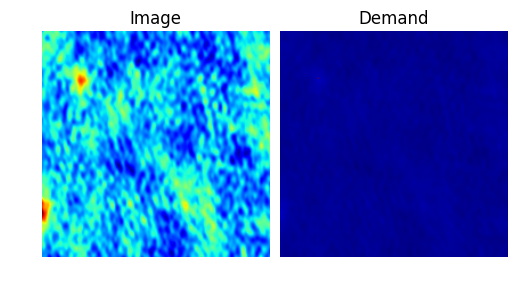

In [29]:
image,demand = ppdp(1)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(6,3)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(image[0,:,:,0])
ax.set_title('Image')
plt.axis('off');

ax = plt.subplot(gs[0, 1])
ax.imshow(demand[0,:,:,0])
ax.set_title('Demand')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

Above, we do not use any kernel to produce demand. It is good to using a sequense of kernels to make more significant contribution  for point sources in loss function. We can use horn shape and Gaussian kernels. These kernels operate like:

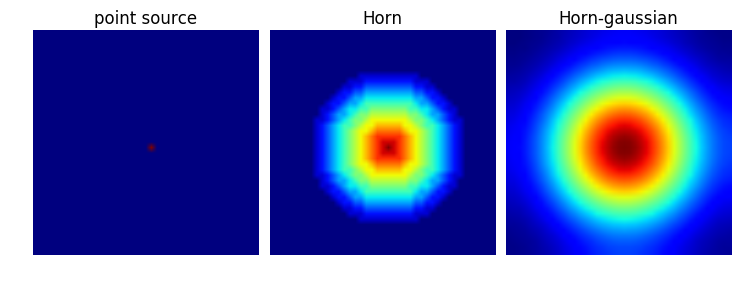

In [30]:
d_example = np.zeros((41,41))
d_example[21,21] = 1

d_horn = pk.horn_kernel(d_example,radius=15,step_height=2)
d_horn_gauss = pk.gaussian_kernel(d_horn,sigma=7)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(9,3)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(d_example)
ax.set_title('point source')
plt.axis('off');

ax = plt.subplot(gs[0, 1])
ax.imshow(d_horn)
ax.set_title('Horn')
plt.axis('off');

ax = plt.subplot(gs[0, 2])
ax.imshow(d_horn_gauss)
ax.set_title('Horn-gaussian')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

You can add any desired kernel to "PreProcessDataProvider":

number of files:  3


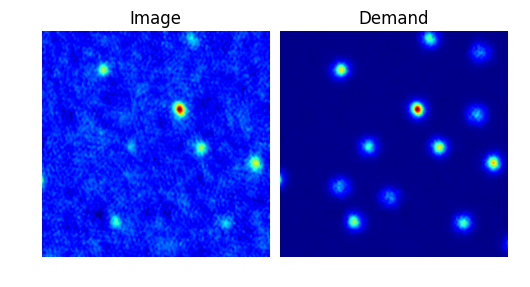

In [34]:
rb = 0
restore=0
patch_size = 400

def kernel1(cat):
    return pk.horn_kernel(cat,radius=15,step_height=2)
def kernel2(cat):
    return pk.gaussian_kernel(cat,sigma=10)

ppdp = pk.PreProcessDataProvider(files_path='../../data/24sep/train_set/*robust-'+str(rb)+'*.fits',
                                     nx=patch_size, ny=patch_size, 
                                     kernels=[kernel1,kernel2], b_n=0.05, alpha=0.75)

x,y = ppdp(1)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(6,3)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(x[0,:,:,0])
ax.set_title('Image')
plt.axis('off')

ax = plt.subplot(gs[0, 1])
ax.imshow(y[0,:,:,0])
ax.set_title('Demand')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

Then you can use "ppdp" to feed convolutional neural network (CNN). CNN will be trained to transform an image to corresponding demand. "ConvolutionalLayers" class provides a CNN for this purpose. You can easily specify any desired architecture and train/save/restore it. In bellow example there is an architecture defined in file "arch.py" placed in current directory. You can train you CNN using train method:

In [5]:
rb = 0
restore=0
patch_size = 400

cnn = pk.ConvolutionalLayers(nl=patch_size,learning_rate = 0.001,n_channel=1,
                              restore=1,model_add='./cmodel',arch_file_name='arch')

# cnn.train(ppdp,training_epochs=5,n_s=1, dropout=0.2)

INFO:tensorflow:Restoring parameters from ./cmodel/model


If you want to restore your trained model to use or tue up, you can set the "restore" argument to 1.
Then "conv" methos can transform any image to demand:

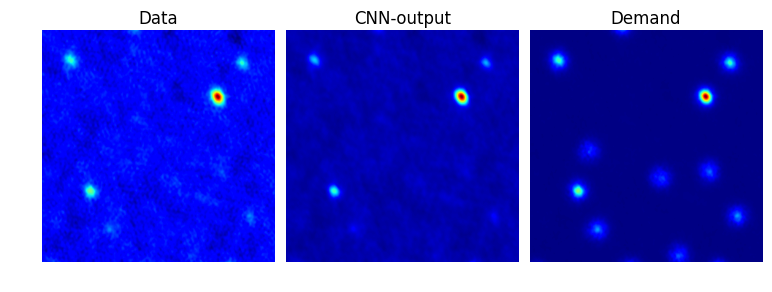

In [5]:
x,y = ppdp(1)
xf = cnn.conv(x)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(7.5,3.5)) 

ax = plt.subplot(gs[0, 0])
plt.axis('off')
ax.set_title('Data')
ax.imshow(x[0,10:-10,10:-10,0])

ax = plt.subplot(gs[0, 1])
plt.axis('off')
ax.set_title('CNN-output')
ax.imshow(xf[10:-10,10:-10])

ax = plt.subplot(gs[0, 2])
plt.axis('off')
ax.set_title('Demand')
ax.imshow(y[0,10:-10,10:-10,0])

plt.subplots_adjust(wspace=0.05,bottom=0.0, top=0.92, left=0.02, right=0.98)

Now let's transform a whole image and extract point sources from demand map. Since operating on a large image may consume big amount of memory, there is a method to do this job by tiling. 

In [25]:
image_file = '../../data/24sep/test_set/stimela-image_image121_24SEP_robust-0-image.fits'
model_file = '../../data/24sep/test_set/image121.txt'

catalog = pk.ps_extract(image_file,model_file,cnn,pk.fetch_data,loc_det='peak',
                        ignore_border=500,jump_lim=100,area_lim=10)

570  point sources are found!


214  points are in noisy borders!


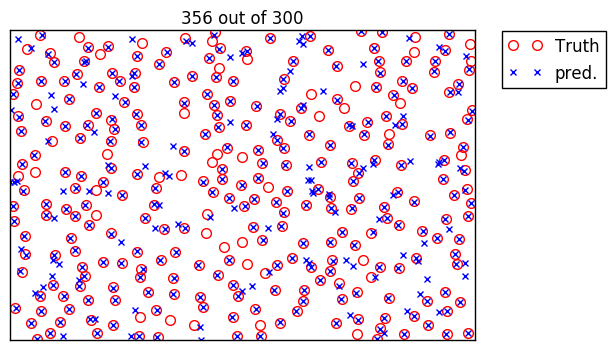

In [21]:
pk.visualize_cross_match(image_file,model_file,catalog)

In [26]:
%load_ext autoreload
%autoreload 2
import imp
imp.reload(pk)
    
output_csv_file = './ps_cat/0_123.csv'

_,number_of_sources = pk.full_completeness_purity(image_file,model_file,catalog,output_csv_file,
                                                  ignore_border=500, quality_threshold=0.9)
print number_of_sources

# mean 394
# peak 378
# com 388

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Iterating over ground truth sources: 100%|██████████| 300/300 [00:14<00:00, 21.15it/s]


378


(0.9341329225922596, 3.9212680362675005)


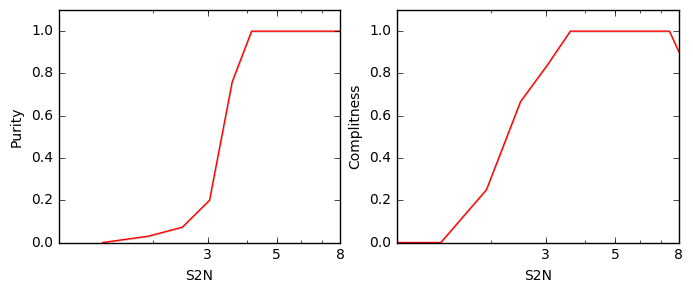

In [27]:
csv_list = glob.glob('./ps_cat/0_123.csv')

import matplotlib.pylab as plt
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2)
plt.figure(figsize =(8,3))

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

print pk.PC_mean_plot(ax0,ax1,csv_list,do_labels=True,s2n=4.)

ax0.set_xscale('log')
ax0.set_xlim(1,8)
ax0.set_ylim(0,1.1)             
ax0.set_xticks([3,5,8])
ax0.set_xticklabels([3,5,8])
ax1.set_xscale('log')
ax1.set_xlim(1,8)
ax1.set_ylim(0,1.1)
ax1.set_xticks([3,5,8])
ax1.set_xticklabels([3,5,8])
plt.legend(loc='best')

# mean (0.6566051116677564, 4.6390907497292)
# peak (0.9341329225922596, 3.9212680362675005)
# com (0.8750727917088663, 3.926884174631457)

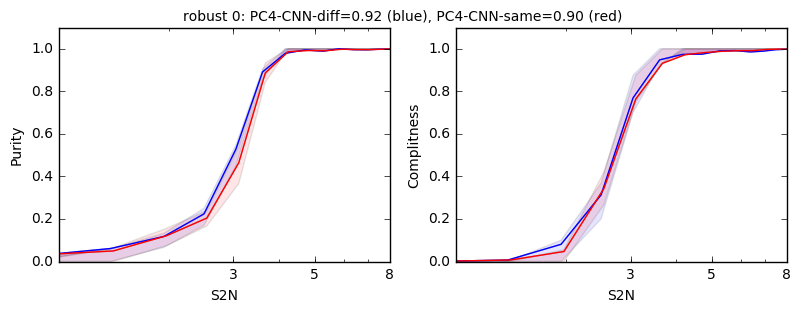

In [14]:
import matplotlib.pylab as plt
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2)
plt.figure(figsize =(8,3))

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])

rb = '0'
csv_list = glob.glob('/home/gf/work/forsat/AIMS_works/radio_source/results/different/res/ps_cat'+rb+'/'+rb+'_*.csv')

csv_list = ['/home/gf/work/forsat/AIMS_works/radio_source/results/different/res/ps_cat'+rb+'/'+rb+'_'+str(i)+
            '.csv' for i in range(101,152)]

pc5_cnn,pcc_cnn = pk.PC_mean_plot(ax0,ax1,csv_list,do_labels=True,s2n=4.,clr='b')

# csv_list = glob.glob('/home/gf/work/forsat/AIMS_works/radio_source/results/different/\
# different_field_2sig-isl_1sig-peak_cropped-500-3600_robust0_cm-9-2p5-2_cp/\
# stimela-image_image*_25SEP_robust-'+rb+'-image_cp.csv')

# csv_list = ['/home/gf/work/forsat/AIMS_works/radio_source/results/different/\
# different_field_2sig-isl_1sig-peak_cropped-500-3600_robust'+rb+'_cm-9-2p5-2_cp/\
# stimela-image_image'+str(i)+'_25SEP_robust-'+rb+'-image_cp.csv' for i in range(101,152)]

csv_list = ['/home/gf/work/forsat/AIMS_works/radio_source/results/samefield/res_same/ps_cat'+rb+'/'+rb+'_'+str(i)+
            '.csv' for i in range(101,152)]

pc5_bdsf,pcc_bdsf = pk.PC_mean_plot(ax0,ax1,csv_list,do_labels=False,s2n=4.,clr='r')


ax0.set_xscale('log')
ax0.set_xlim(1,8)
ax0.set_ylim(0,1.1)             
ax0.set_xticks([3,5,8])
ax0.set_xticklabels([3,5,8])
ax1.set_xscale('log')
ax1.set_xlim(1,8)
ax1.set_ylim(0,1.1)
ax1.set_xticks([3,5,8])
ax1.set_xticklabels([3,5,8])
plt.legend(loc='best')

plt.suptitle('robust {}: PC4-CNN-diff={:2.2f} (blue), PC4-CNN-same={:2.2f} (red)'.format(rb,pc5_cnn,pc5_bdsf))
plt.subplots_adjust(wspace=0.2,bottom=0.14, top=0.92, left=0.07, right=0.98)
plt.savefig('diff_pybdsf-robust-'+rb+'.jpg')

In [15]:
print pc5_bdsf,pc5_cnn
print pcc_bdsf,pcc_cnn

0.903484536308 0.921719418106
3.74125193227 3.65882851908


In [ ]:


np.round(np.mean(np.argwhere(filt),axis=0)).astype(int)

[51 51]
[59 59]
[61 61]


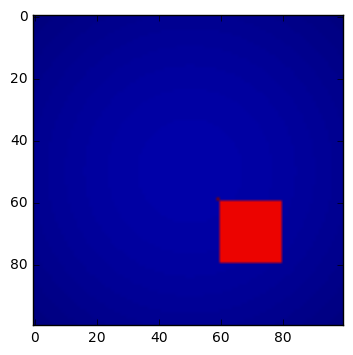

In [87]:
d = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        d[i,j]=np.exp(-0.0001*((i-50)**2+(j-50)**2))

d[59,59]=11
d[60:80,60:80]=10

plt.imshow(d)

filt = d>0.9

# plt.imshow(filt)

print np.round(np.mean(np.argwhere(filt),axis=0)).astype(int)
print np.array([np.where(d==np.max(d[filt]))[0][0],np.where(d==np.max(d[filt]))[1][0]]).astype(int)
print cent_of_mass(d,filt)

In [86]:
def cent_of_mass(d,filt):
    indx = np.where(filt)[0]
    indy = np.where(filt)[1]
    li = 0
    lj = 0
    mass = 0
    for i,j in zip(indx,indy):
        val = d[i,j]
        mass += val
        li += val*i
        lj += val*j
    li /= mass
    lj /= mass
    return np.round(np.array([li,lj])).astype(int)